In [ ]:
import json
from google.colab import drive
import pandas as pd
import requests
import random
import time
from pandas.io.json import json_normalize
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

********************************************
#Getting the data

In [ ]:
# read in all players from the balldontlie api
allplayers=[]
for i in range(1, 53):
  url = "https://www.balldontlie.io/api/v1/players?per_page=100&page=" + str(i)
  response = requests.get(url)
  data = response.json()
  allplayers = allplayers + data['data']

In [ ]:
# restrict my player data to only players that have measured height values(this helps narrow my list to more recent players)
players = []
for player in allplayers:
  if player['height_feet'] != None:
    players.append(player)

In [ ]:
# create the urls to grab stats for each player
ids1 = ""
ids2 = ""
for i in range(len(players)):
  if i < len(players)/2:
    ids1 = ids1 + "&player_ids[]=" + str(players[i]['id'])
  else:
    ids2 = ids2 + "&player_ids[]=" + str(players[i]['id'])

In [ ]:
# we have 479 players in our set
len(players)

479

In [ ]:
# grab the stats from each player
url1 = "https://www.balldontlie.io/api/v1/season_averages?season=2022" + ids1
url2 = "https://www.balldontlie.io/api/v1/season_averages?season=2022" + ids2
response1 = requests.get(url1)
stats1 = response1.json()
response2 = requests.get(url2)
stats2 = response2.json()
stats = stats1['data'] + stats2['data']

In [ ]:
# notice we narrowed our player dataset to only players that had stats in the 2020 season
len(stats)

251

********************************************
#Cleaning Data

In [ ]:
# transform my data into dataframes
df_players = json_normalize(players)
df_players.set_index('id', inplace=True)
df_stats = json_normalize(stats)
df_stats.set_index('player_id', inplace=True)

<ipython-input-8-17af71fc165e>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df_players = json_normalize(players)
<ipython-input-8-17af71fc165e>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df_stats = json_normalize(stats)


In [ ]:
# combine my player and stats datasets
df_playerstats = df_players.merge(df_stats, how='inner', left_index=True, right_index=True)

In [ ]:
df_playerstats.head()

,first_name,height_feet,height_inches,last_name,position,weight_pounds,team.id,team.abbreviation,team.city,team.conference,...,reb,ast,stl,blk,turnover,pf,pts,fg_pct,fg3_pct,ft_pct
78,Deonte,6,5,Burton,G,245,26,SAC,Sacramento,West,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.00,0.00
459,Noah,6,9,Vonleh,F,250,2,BOS,Boston,East,...,2.09,0.30,0.09,0.35,0.48,1.52,1.09,0.458,0.25,1.00
240,Alize,6,9,Johnson,F,212,27,SAS,San Antonio,West,...,2.50,0.25,0.25,0.00,1.00,0.75,1.75,0.500,0.00,0.50
133,Tyler,6,5,Dorsey,G,183,7,DAL,Dallas,West,...,0.67,0.00,0.00,0.00,0.00,0.00,3.00,0.800,0.50,0.00
465,Kemba,6,1,Walker,G,184,7,DAL,Dallas,West,...,1.78,2.11,0.22,0.22,0.44,1.22,8.00,0.421,0.25,0.81


In [ ]:
df_playerstats.columns

Index(['first_name', 'height_feet', 'height_inches', 'last_name', 'position',
       'weight_pounds', 'team.id', 'team.abbreviation', 'team.city',
       'team.conference', 'team.division', 'team.full_name', 'team.name',
       'games_played', 'season', 'min', 'fgm', 'fga', 'fg3m', 'fg3a', 'ftm',
       'fta', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'turnover', 'pf',
       'pts', 'fg_pct', 'fg3_pct', 'ft_pct'],
      dtype='object')

In [ ]:
# calculate the total fantasy points for each player in the 2020 season
df_playerstats['total fantasy points'] = (((df_playerstats['pts'] * 1) +
                                          (df_playerstats['reb'] * 1.2) +
                                          (df_playerstats['ast'] * 1.5) +
                                          (df_playerstats['stl'] * 3) +
                                          (df_playerstats['blk'] * 3) -
                                          (df_playerstats['turnover'] * 1)) *
                                          df_playerstats['games_played']
)

# calculate the average fantasy points for each player in the 2020 season
df_playerstats['average fantasy points'] = (((df_playerstats['pts'] * 1) +
                                          (df_playerstats['reb'] * 1.2) +
                                          (df_playerstats['ast'] * 1.5) +
                                          (df_playerstats['stl'] * 3) +
                                          (df_playerstats['blk'] * 3) -
                                          (df_playerstats['turnover'] * 1))
)

In [ ]:
# creating another minutes played variable that holds seconds values as an integer
df_playerstats['min(sec)'] = df_playerstats['min'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

In [ ]:
# creating per 36 stats
df_playerstats['pts_per36'] = ((36*60) / df_playerstats['min(sec)']) * df_playerstats['pts']
df_playerstats['reb_per36'] = ((36*60) / df_playerstats['min(sec)']) * df_playerstats['reb']
df_playerstats['ast_per36'] = ((36*60) / df_playerstats['min(sec)']) * df_playerstats['ast']
df_playerstats['stl_per36'] = ((36*60) / df_playerstats['min(sec)']) * df_playerstats['stl']
df_playerstats['blk_per36'] = ((36*60) / df_playerstats['min(sec)']) * df_playerstats['blk']

In [ ]:
# creating a combined height variable
df_playerstats['height'] = df_playerstats['height_feet'] + (df_playerstats['height_inches']/12)

********************************************
#Categories Scoring

Categories: FG%, FT%, 3PM, REB, AST, STL, BLK, PTS

In [ ]:
df_playerstats.columns

Index(['first_name', 'height_feet', 'height_inches', 'last_name', 'position',
       'weight_pounds', 'team.id', 'team.abbreviation', 'team.city',
       'team.conference', 'team.division', 'team.full_name', 'team.name',
       'games_played', 'season', 'min', 'fgm', 'fga', 'fg3m', 'fg3a', 'ftm',
       'fta', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'turnover', 'pf',
       'pts', 'fg_pct', 'fg3_pct', 'ft_pct', 'total fantasy points',
       'average fantasy points', 'min(sec)', 'pts_per36', 'reb_per36',
       'ast_per36', 'stl_per36', 'blk_per36', 'height'],
      dtype='object')

In [ ]:
# Create a pipeline to group my players into 4 groups by efficiency and per 36 stats

# X_train = df_playerstats[['fg_pct', 'ft_pct', 'fg3m', 'reb', 'ast', 'stl', 'blk', 'pts']]
X_train = df_playerstats[['fg_pct', 'ft_pct', 'fg3m', 'reb_per36', 'ast_per36', 'stl_per36', 'blk_per36', 'pts_per36']]
# X_train = df_playerstats[['fg_pct', 'ft_pct', 'fg3_pct']]
pipeline = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=4)
)
pipeline.fit(X_train)

df_playerstats['type'] = pipeline.named_steps['kmeans'].labels_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


********************************************
# Data Exploration

In [ ]:
df_playerstats.groupby('type')[['fg_pct', 'ft_pct', 'fg3m', 'reb_per36', 'ast_per36', 'stl_per36', 'blk_per36', 'pts_per36', 'min(sec)', 'height']].mean().round(1)

,fg_pct,ft_pct,fg3m,reb_per36,ast_per36,stl_per36,blk_per36,pts_per36,min(sec),height
type,,,,,,,,,,
0,0.6,0.7,0.4,10.8,2.4,0.9,1.4,16.6,1199.4,6.9
1,0.4,0.8,1.1,5.3,3.6,1.2,0.5,13.0,1219.8,6.5
2,0.5,0.8,2.3,5.5,5.3,1.1,0.5,23.0,1946.8,6.5
3,0.1,0.0,0.1,7.1,3.9,1.6,0.1,3.0,335.4,6.4


In [ ]:
X_train = df_playerstats[["pts", "reb", "ast", "stl", "blk", "height"]]
y_train = df_playerstats["type"]

pipeline1 = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=15)
)

pipeline1.fit(X_train, y_train)

pipeline1.predict([[10, 15, 3, 2, .5, 7]])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0], dtype=int32)

In [ ]:
df_playerstats[df_playerstats['team.name'] == 'Suns']

,first_name,height_feet,height_inches,last_name,position,weight_pounds,team.id,team.abbreviation,team.city,team.conference,...,total fantasy points,average fantasy points,min(sec),pts_per36,reb_per36,ast_per36,stl_per36,blk_per36,height,type
367,Chris,6,0,Paul,G,175,24,PHX,Phoenix,West,...,2131.670,36.130,1923,15.590640,4.773791,9.996880,1.729797,0.415601,6.000000,2
140,Kevin,6,9,Durant,F,240,24,PHX,Phoenix,West,...,2241.054,47.682,2134,29.414058,6.741143,5.060918,0.728772,1.447423,6.750000,2
48,Bismack,6,9,Biyombo,C,255,24,PHX,Phoenix,West,...,923.540,15.140,856,10.875701,10.724299,2.271028,0.757009,3.633645,6.750000,0
469,T.J.,6,8,Warren,F,215,24,PHX,Phoenix,West,...,602.952,14.356,981,16.469725,6.341284,2.157798,1.144954,0.638532,6.666667,1
57,Devin,6,6,Booker,G,210,24,PHX,Phoenix,West,...,2259.973,42.641,2077,28.858931,4.711026,5.750987,0.998363,0.353587,6.500000,2
22,Deandre,7,1,Ayton,C,250,24,PHX,Phoenix,West,...,2326.374,34.722,1824,21.268421,11.794737,2.036842,0.651316,0.935526,7.083333,0
402,Terrence,6,7,Ross,G-F,206,24,PHX,Phoenix,West,...,941.409,14.943,1265,14.155257,4.166324,2.578340,0.956206,0.273202,6.583333,1
272,Damion,6,6,Lee,G,210,24,PHX,Phoenix,West,...,1055.832,14.268,1222,14.423568,5.373486,2.368576,0.724714,0.159083,6.500000,1
110,Torrey,6,7,Craig,F,215,24,PHX,Phoenix,West,...,1536.392,19.448,1482,10.843725,7.855870,2.157085,0.918219,1.136842,6.583333,1
356,Josh,6,4,Okogie,G,212,24,PHX,Phoenix,West,...,1192.896,16.568,1122,14.149733,6.718717,2.772193,1.501604,0.904813,6.333333,1


In [ ]:
# lets look at the top total fantasy point scorers from the 2020 season and what types they are
df_playerstats.sort_values(by='total fantasy points', ascending = False)[['first_name', 'last_name', 'team.full_name', 'height', 'type']].head(n=7)

,first_name,last_name,team.full_name,height,type
246,Nikola,Jokic,Denver Nuggets,7.000000,2
132,Luka,Doncic,Dallas Mavericks,6.583333,2
145,Joel,Embiid,Philadelphia 76ers,7.000000,0
434,Jayson,Tatum,Boston Celtics,6.666667,2
406,Domantas,Sabonis,Sacramento Kings,6.916667,0
175,Shai,Gilgeous-Alexander,Oklahoma City Thunder,6.500000,2
15,Giannis,Antetokounmpo,Milwaukee Bucks,6.916667,0


In [ ]:
# how about the top average fantasy point scorers from the 2020 season and what types they are
df_playerstats.sort_values(by='average fantasy points', ascending = False)[['first_name', 'last_name', 'team.full_name', 'height', 'type']].head(n=10)

,first_name,last_name,team.full_name,height,type
132,Luka,Doncic,Dallas Mavericks,6.583333,2
145,Joel,Embiid,Philadelphia 76ers,7.000000,0
246,Nikola,Jokic,Denver Nuggets,7.000000,2
15,Giannis,Antetokounmpo,Milwaukee Bucks,6.916667,0
117,Anthony,Davis,Los Angeles Lakers,6.833333,0
175,Shai,Gilgeous-Alexander,Oklahoma City Thunder,6.500000,2
237,LeBron,James,Los Angeles Lakers,6.666667,2
434,Jayson,Tatum,Boston Celtics,6.666667,2
278,Damian,Lillard,Portland Trail Blazers,6.250000,2
140,Kevin,Durant,Phoenix Suns,6.750000,2


<Axes: xlabel='reb', ylabel='ast'>

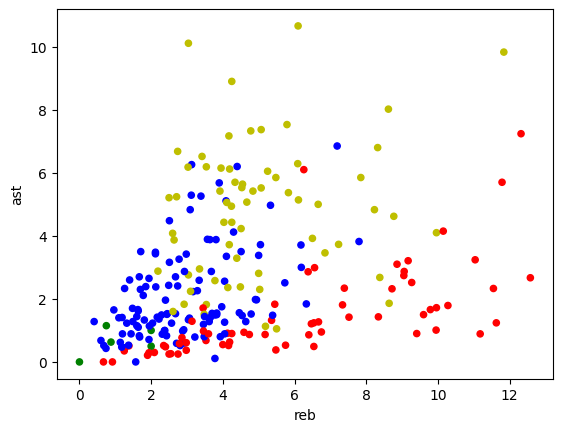

In [ ]:
cluster = pd.Series(df_playerstats['type']).map({
    0: "r",
    1: "b",
    2: "y",
    3: "g"
})

df_playerstats.plot.scatter(x="reb", y="ast", color= cluster)

********************************************
# Giannis Antetekounmpo vs Nikola Jokic

In [ ]:
# get the data for Giannis and Nikola
gj = []
for i in range(15, 23):
  response = requests.get('https://www.balldontlie.io/api/v1/season_averages?player_ids[]=15&player_ids[]=246&season=20'+str(i))
  data = response.json()
  gj = gj + data['data']

In [ ]:
# split the data for each player
data_giannis = []
data_jokic = []
for season in gj:
  if season['player_id'] == 15:
    data_giannis.append(season)
  else:
    data_jokic.append(season)

In [ ]:
# Transform the data into Dataframes and set index
df_giannis = json_normalize(data_giannis)
df_giannis['season'] = pd.to_datetime(df_giannis['season'], format="%Y")
df_giannis.set_index('season', inplace = True)
df_nikola = json_normalize(data_jokic)
df_nikola['season'] = pd.to_datetime(df_nikola['season'], format="%Y")
df_nikola.set_index('season', inplace = True)

<ipython-input-25-79110f8a5bc8>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df_giannis = json_normalize(data_giannis)
<ipython-input-25-79110f8a5bc8>:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df_nikola = json_normalize(data_jokic)


In [ ]:
# calculate average and total fantasy points
df_giannis['total fantasy points'] = (((df_giannis['pts'] * 1) +
                                          (df_giannis['reb'] * 1.2) +
                                          (df_giannis['ast'] * 1.5) +
                                          (df_giannis['stl'] * 3) +
                                          (df_giannis['blk'] * 3) -
                                          (df_giannis['turnover'] * 1)) *
                                          df_giannis['games_played']
)
df_giannis['average fantasy points'] = (((df_giannis['pts'] * 1) +
                                          (df_giannis['reb'] * 1.2) +
                                          (df_giannis['ast'] * 1.5) +
                                          (df_giannis['stl'] * 3) +
                                          (df_giannis['blk'] * 3) -
                                          (df_giannis['turnover'] * 1))
)

df_nikola['total fantasy points'] = (((df_nikola['pts'] * 1) +
                                          (df_nikola['reb'] * 1.2) +
                                          (df_nikola['ast'] * 1.5) +
                                          (df_nikola['stl'] * 3) +
                                          (df_nikola['blk'] * 3) -
                                          (df_nikola['turnover'] * 1)) *
                                          df_nikola['games_played']
)
df_nikola['average fantasy points'] = (((df_nikola['pts'] * 1) +
                                          (df_nikola['reb'] * 1.2) +
                                          (df_nikola['ast'] * 1.5) +
                                          (df_nikola['stl'] * 3) +
                                          (df_nikola['blk'] * 3) -
                                          (df_nikola['turnover'] * 1))
)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


array([3480.87445068])

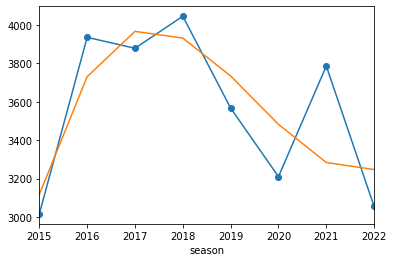

In [ ]:
# set/plot/predict a regression model (Giannis total points)
season = df_giannis.index
t = season.year

pipeline = make_pipeline(
    PolynomialFeatures(degree=4, include_bias=False),
    LinearRegression()
)

y_train = df_giannis['total fantasy points']

pipeline.fit(X=t.to_frame(), y=y_train)

y_train_ = pd.Series(
    pipeline.predict(X=t.to_frame()),
    index=y_train.index
)

y_train.plot.line(style="o-")
y_train_.plot.line()

pipeline.predict([[2023]])

<Axes: xlabel='season'>

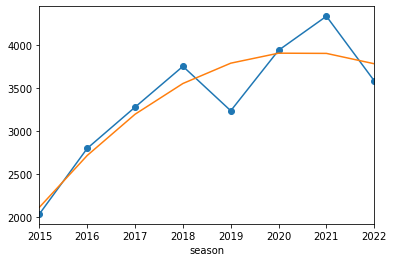

In [ ]:
# set/plot/predict a regression model (Nikola total points)
season = df_nikola.index
t = season.year

pipeline = make_pipeline(
    PolynomialFeatures(degree=4, include_bias=False),
    LinearRegression()
)

y_train = df_nikola['total fantasy points']

pipeline.fit(X=t.to_frame(), y=y_train)

y_train_ = pd.Series(
    pipeline.predict(X=t.to_frame()),
    index=y_train.index
)

y_train.plot.line(style="o-", label='actual')
y_train_.plot.line(label='predicted')

#pipeline.predict([[2023]])

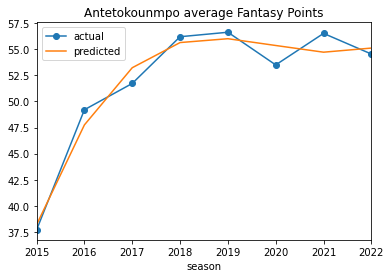

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


array([57.5715012])

In [ ]:
# set/plot/predict a regression model (Giannis average points)
season = df_giannis.index
t = season.year

pipeline = make_pipeline(
    PolynomialFeatures(degree=4, include_bias=False),
    LinearRegression()
)

y_train = df_giannis['average fantasy points']

pipeline.fit(X=t.to_frame(), y=y_train)

y_train_ = pd.Series(
    pipeline.predict(X=t.to_frame()),
    index=y_train.index
)

y_train.plot.line(style="o-", label='actual')
y_train_.plot.line(label='predicted')
plt.title('Antetokounmpo average Fantasy Points')
plt.legend()
plt.show()
pipeline.predict([[2023]])

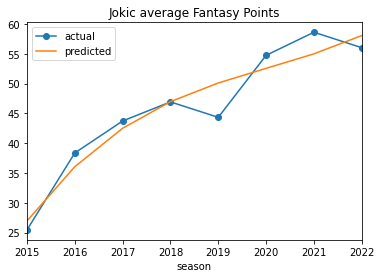

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


array([62.40297469])

In [ ]:
# set/plot/predict a regression model (Nikola average points)
season = df_nikola.index
t = season.year

pipeline = make_pipeline(
    PolynomialFeatures(degree=4, include_bias=False),
    LinearRegression()
)

y_train = df_nikola['average fantasy points']

pipeline.fit(X=t.to_frame(), y=y_train)

y_train_ = pd.Series(
    pipeline.predict(X=t.to_frame()),
    index=y_train.index
)

y_train.plot.line(style="o-", label='actual')
y_train_.plot.line(label='predicted')
plt.title('Jokic average Fantasy Points')
plt.legend()
plt.show()

pipeline.predict([[2023]])

********************************************
# Getting/Cleaning Jokic Data

In [ ]:
# Finding Jokic's player id for the api pull
df_playerstats[df_playerstats['last_name'] == 'Jokic']

,first_name,height_feet,height_inches,last_name,position,weight_pounds,team.id,team.abbreviation,team.city,team.conference,...,total fantasy points,average fantasy points,min(sec),pts_per36,reb_per36,ast_per36,stl_per36,blk_per36,height,type
246,Nikola,7,0,Jokic,C,250,8,DEN,Denver,West,...,3584.448,56.007,2036,26.236149,12.635363,10.513556,1.304912,0.700196,7.0,1


In [ ]:
# get all game stats from the 2017-2022 seasons for Jokic
data_jokic=[]
for i in range(1, 6):
  response = requests.get("https://www.balldontlie.io/api/v1/stats?seasons[]=2017&seasons[]=2018&seasons[]=2019&seasons[]=2020&seasons[]=2021&seasons[]=2022&player_ids[]=246&per_page=100&page="+ str(i))
  data = response.json()
  data_jokic = data_jokic + data['data']
df_jokic = json_normalize(data_jokic)
df_jokic.dropna(inplace=True)

<ipython-input-32-f49419693fd1>:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df_jokic = json_normalize(data_jokic)


In [ ]:
# get data for all nba teams
response = requests.get("https://www.balldontlie.io/api/v1/teams")
data = response.json()
df_teams = json_normalize(data['data'])
df_teams.set_index('id', inplace=True)

<ipython-input-33-28d3019d936b>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df_teams = json_normalize(data['data'])


In [ ]:
df_teams.columns

Index(['abbreviation', 'city', 'conference', 'division', 'full_name', 'name'], dtype='object')

In [ ]:
df_jokic.columns

Index(['id', 'ast', 'blk', 'dreb', 'fg3_pct', 'fg3a', 'fg3m', 'fg_pct', 'fga',
       'fgm', 'ft_pct', 'fta', 'ftm', 'min', 'oreb', 'pf', 'pts', 'reb', 'stl',
       'turnover', 'game.id', 'game.date', 'game.home_team_id',
       'game.home_team_score', 'game.period', 'game.postseason', 'game.season',
       'game.status', 'game.time', 'game.visitor_team_id',
       'game.visitor_team_score', 'player.id', 'player.first_name',
       'player.height_feet', 'player.height_inches', 'player.last_name',
       'player.position', 'player.team_id', 'player.weight_pounds', 'team.id',
       'team.abbreviation', 'team.city', 'team.conference', 'team.division',
       'team.full_name', 'team.name'],
      dtype='object')

In [ ]:
# get the team id of the nuggets
df_teams[df_teams['full_name'] == 'Denver Nuggets']

,abbreviation,city,conference,division,full_name,name
id,,,,,,
8,DEN,Denver,West,Northwest,Denver Nuggets,Nuggets


In [ ]:
# get opponent and whether the nuggets won or not for each game
opponent = []
win = []
for index, row in df_jokic.iterrows():
  home = None
  if row['game.home_team_id'] == 8: home = True
  else: home = False
  if home:
    opponent.append(df_teams.loc[row['game.visitor_team_id']]['full_name'])
    if row['game.visitor_team_score'] > row['game.home_team_score']:
      win.append(0)
    else:
      win.append(1)
  else:
    opponent.append(df_teams.loc[row['game.home_team_id']]['full_name'])
    if row['game.visitor_team_score'] > row['game.home_team_score']:
      win.append(1)
    else:
      win.append(0)

In [ ]:
df_jokic['game.date'] = df_jokic['game.date'].str.slice(stop=10)
df_jokic['game.date'] = pd.to_datetime(df_jokic['game.date'], format="%Y-%m-%d")

In [ ]:
date = []
for index, row in df_jokic.iterrows():
  date.append((row['game.date'].month - 1) + (row['game.date'].day/30))

In [ ]:
# creating a cleaned up Jokic game dataframe
df_jokic = df_jokic[['ast', 'blk', 'dreb', 'fg3_pct', 'fg3a', 'fg3m', 'fg_pct', 'fga',
       'fgm', 'ft_pct', 'fta', 'ftm', 'min', 'oreb', 'pf', 'pts', 'reb', 'stl',
       'turnover', 'game.date', 'game.season']]
df_jokic['opponent'] = opponent
df_jokic['win'] = win
df_jokic['calender date'] = date

<ipython-input-40-ef4a1cd66065>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jokic['opponent'] = opponent
<ipython-input-40-ef4a1cd66065>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jokic['win'] = win
<ipython-input-40-ef4a1cd66065>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [ ]:
df_jokic['fantasy points'] = (((df_jokic['pts'] * 1) +
                              (df_jokic['reb'] * 1.2) +
                              (df_jokic['ast'] * 1.5) +
                              (df_jokic['stl'] * 3) +
                              (df_jokic['blk'] * 3) -
                              (df_jokic['turnover'] * 1))
)

<ipython-input-41-a2b4dcfa795b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jokic['fantasy points'] = (((df_jokic['pts'] * 1) +


In [ ]:
df_jokic.head()

,ast,blk,dreb,fg3_pct,fg3a,fg3m,fg_pct,fga,fgm,ft_pct,...,pts,reb,stl,turnover,game.date,game.season,opponent,win,calender date,fantasy points
0,11.0,1.0,4.0,0.00,3.0,0.0,0.333,18.0,6.0,1.000,...,18.0,8.0,1.0,2.0,2019-01-17,2018,Chicago Bulls,1,0.566667,48.1
1,12.0,0.0,8.0,0.50,6.0,3.0,0.667,12.0,8.0,0.000,...,19.0,11.0,1.0,1.0,2019-01-19,2018,Cleveland Cavaliers,1,0.633333,52.2
2,5.0,2.0,6.0,0.25,4.0,1.0,0.462,13.0,6.0,0.800,...,21.0,8.0,1.0,2.0,2018-10-17,2018,LA Clippers,1,9.566667,45.1
3,11.0,1.0,11.0,1.00,3.0,3.0,1.000,11.0,11.0,0.909,...,35.0,11.0,4.0,0.0,2018-10-20,2018,Phoenix Suns,1,9.666667,79.7
4,6.0,0.0,8.0,0.00,1.0,0.0,0.500,14.0,7.0,0.750,...,23.0,11.0,0.0,2.0,2018-10-21,2018,Golden State Warriors,1,9.700000,43.2


********************************************
# Getting/Cleaning Antetokounmpo Data

In [ ]:
# Finding Giannis' player id for the api pull
df_playerstats[df_playerstats['last_name'] == 'Antetokounmpo']

,first_name,height_feet,height_inches,last_name,position,weight_pounds,team.id,team.abbreviation,team.city,team.conference,...,total fantasy points,average fantasy points,min(sec),pts_per36,reb_per36,ast_per36,stl_per36,blk_per36,height,type
15,Giannis,6,11,Antetokounmpo,F,242,17,MIL,Milwaukee,East,...,3054.296,54.541,1953,34.562212,13.139171,6.160369,0.807373,0.884793,6.916667,0


In [ ]:
# get all game stats from the 2017-2022 seasons for Giannis
data_ant=[]
for i in range(1, 6):
  response = requests.get("https://www.balldontlie.io/api/v1/stats?seasons[]=2017&seasons[]=2018&seasons[]=2019&seasons[]=2020&seasons[]=2021&seasons[]=2022&player_ids[]=15&per_page=100&page="+ str(i))
  data = response.json()
  data_ant = data_ant + data['data']
df_ant = json_normalize(data_ant)
df_ant.dropna(inplace=True)

<ipython-input-44-4cff432fe290>:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df_ant = json_normalize(data_ant)


In [ ]:
# get the team id of the nuggets
df_teams[df_teams['full_name'] == 'Milwaukee Bucks']

,abbreviation,city,conference,division,full_name,name
id,,,,,,
17,MIL,Milwaukee,East,Central,Milwaukee Bucks,Bucks


In [ ]:
# get opponent and whether the nuggets won or not for each game
opponent = []
win = []
for index, row in df_ant.iterrows():
  home = None
  if row['game.home_team_id'] == 17: home = True
  else: home = False
  if home:
    opponent.append(df_teams.loc[row['game.visitor_team_id']]['full_name'])
    if row['game.visitor_team_score'] > row['game.home_team_score']:
      win.append(0)
    else:
      win.append(1)
  else:
    opponent.append(df_teams.loc[row['game.home_team_id']]['full_name'])
    if row['game.visitor_team_score'] > row['game.home_team_score']:
      win.append(1)
    else:
      win.append(0)

In [ ]:
df_ant['game.date'] = df_ant['game.date'].str.slice(stop=10)
df_ant['game.date'] = pd.to_datetime(df_ant['game.date'], format="%Y-%m-%d")

In [ ]:
date = []
for index, row in df_ant.iterrows():
  date.append((row['game.date'].month - 1) + (row['game.date'].day/30))

In [ ]:
# creating a cleaned up Giannis game dataframe
df_ant = df_ant[['ast', 'blk', 'dreb', 'fg3_pct', 'fg3a', 'fg3m', 'fg_pct', 'fga',
       'fgm', 'ft_pct', 'fta', 'ftm', 'min', 'oreb', 'pf', 'pts', 'reb', 'stl',
       'turnover', 'game.date', 'game.season']]
df_ant['opponent'] = opponent
df_ant['win'] = win
df_ant['calender date'] = date

In [ ]:
df_ant['fantasy points'] = (((df_ant['pts'] * 1) +
                              (df_ant['reb'] * 1.2) +
                              (df_ant['ast'] * 1.5) +
                              (df_ant['stl'] * 3) +
                              (df_ant['blk'] * 3) -
                              (df_ant['turnover'] * 1))
)

In [ ]:
df_ant.head()

,ast,blk,dreb,fg3_pct,fg3a,fg3m,fg_pct,fga,fgm,ft_pct,...,pts,reb,stl,turnover,game.date,game.season,opponent,win,calender date,fantasy points
0,5.0,0.0,11.0,0.333,3.0,1.0,0.588,17.0,10.0,0.667,...,25.0,13.0,2.0,5.0,2019-01-19,2018,Orlando Magic,1,0.633333,49.1
1,5.0,0.0,12.0,0.500,2.0,1.0,0.500,20.0,10.0,0.833,...,31.0,15.0,0.0,5.0,2019-01-21,2018,Dallas Mavericks,1,0.700000,51.5
3,8.0,1.0,15.0,0.000,3.0,0.0,0.429,21.0,9.0,0.583,...,25.0,18.0,0.0,8.0,2018-10-17,2018,Charlotte Hornets,1,9.566667,53.6
4,5.0,1.0,12.0,0.000,6.0,0.0,0.522,23.0,12.0,0.667,...,26.0,15.0,2.0,6.0,2018-10-19,2018,Indiana Pacers,1,9.633333,54.5
5,4.0,2.0,6.0,0.333,3.0,1.0,0.448,29.0,13.0,0.667,...,31.0,15.0,0.0,3.0,2018-10-22,2018,New York Knicks,1,9.733333,58.0


********************************************
# Predicting

In [ ]:
# create the model
ct = make_column_transformer(
    (StandardScaler(), ['calender date', 'game.season']),
    (OneHotEncoder(), ['opponent']),
    remainder='drop'
)

pipeline = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors = 5)
)

In [ ]:
X_train = df_jokic[['calender date', 'opponent', 'game.season']]
y_train = df_jokic[['fantasy points']]

pipeline.fit(X=X_train, y=y_train)

df = pd.DataFrame({'opponent': 'Milwaukee Bucks', 'game.season':2023, 'calender date':0}, index=[1])
pipeline.predict(df)

array([[41.1]])

In [ ]:
# Train the model and predict(Antetekounmpo)
X_train = df_ant[['calender date', 'opponent', 'game.season']]
y_train = df_ant[['fantasy points']]

pipeline.fit(X=X_train, y=y_train)

df = pd.DataFrame({'opponent': 'Denver Nuggets', 'game.season':2023, 'calender date':0}, index=[1])
pipeline.predict(df)

array([[39.66]])